In [1]:
import os
import sys
sys.path.insert(0, os.getcwd())

import torch
import random
from omegaconf import DictConfig
from pytorch_lightning import Trainer

import numpy as np

from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.engines import Imputer
from tsl.metrics import numpy as numpy_metrics
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

from fillers.KITS_filler import GCNCycVirtualFiller
from fillers.unnamed_filler import UnnamedKrigFiller
from fillers.unnamed_filler_v2 import UnnamedKrigFillerV2
from fillers.unnamed_filler_v5 import UnnamedKrigFillerV5
from fillers.DIDA_filler import DidaFiller
from fillers.IGNNK_filler import IGNNKFiller

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
from Grin import get_dataset, get_model_class, MODELS

In [2]:
# import torch.nn.functional as F

# def temporal_concat_N_extended(x, window=3):
#     """
#     Concatenate temporal neighbors along the N dimension
#     for input of shape [T, B, N, D1, D2].

#     Returns: [T, B, N * (2*window+1), D1, D2]
#     """
#     T, B, N, D1, D2 = x.shape
#     pad = window

#     # Pad time dimension: [T + 2*pad, B, N, D1, D2]
#     x_padded = F.pad(x, (0, 0, 0, 0, 0, 0, 0, 0, pad, pad))  # only T gets padded

#     # Gather slices across time
#     context = []
#     for offset in range(-window, window + 1):
#         slice_t = x_padded[pad + offset : pad + offset + T]  # [T, B, N, D1, D2]
#         context.append(slice_t)

#     # return context
#     # Concatenate along N → [T, B, N*(2*window+1), D1, D2]
#     x_concat = torch.cat(context, dim=2)
#     return x_concat

# x = torch.randn(10, 2, 5, 4, 3)  # [T=10, B=2, N=5, D1=4, D2=3]
# x_out = temporal_concat_N_extended(x, window=1)
# x


In [3]:
# MODELS = ['kits', 'unkrig', 'kcn', 'unkrigv2', 'unkrigv3', 'ignnk']

# def get_model_class(model_str):
#     if model_str == 'rnni':
#         model = RNNImputerModel
#     elif model_str == 'birnni':
#         model = BiRNNImputerModel
#     elif model_str == 'grin':
#         model = GRINModel
#     elif model_str == 'spin':
#         model = SPINModel
#     elif model_str == 'spin-h':
#         model = SPINHierarchicalModel
#     elif model_str == 'kits':
#         model = KITS
#     elif model_str == 'unkrig':
#         model = UnnamedKrigModel
#     elif model_str == 'unkrigv2':
#         model = UnnamedKrigModelV2
#     elif model_str == 'unkrigv3':
#         model = UnnamedKrigModelV3
#     elif model_str == 'ignnk':
#         model = IGNNK
#     else:
#         raise NotImplementedError(f'Model "{model_str}" not available.')
#     return model


# def get_dataset(dataset_name: str, p_fault=0., p_noise=0., t_range = ['2022-04-01', '2022-12-01'],
#                 masked_s=None, agg_func = 'mean', test_month=[5], location='Auckland', connectivity=None, mode='road'):
#     if dataset_name == 'air':
#         return AirQualityKrig(impute_nans=True, small=True, masked_sensors=masked_s, p=p_noise), masked_s
#     if dataset_name == 'air_smaller':
#         return AirQualitySmaller('../../AirData/AQI/Stations', impute_nans=True, masked_sensors=masked_s), masked_s
#     if dataset_name == 'air_auckland' or dataset_name == 'air_invercargill1' or dataset_name == 'air_invercargill2':
#         return AirQualityAuckland('../../AirData/Niwa', t_range=t_range, masked_sensors=masked_s, 
#                                   agg_func=agg_func, test_months=test_month,
#                                   location=location, p=p_noise), masked_s
#     if dataset_name.endswith('_point'):
#         p_fault, p_noise = 0., 0.25
#         dataset_name = dataset_name[:-6]
#     if dataset_name.endswith('_block'):
#         p_fault, p_noise = 0.0015, 0.05
#         dataset_name = dataset_name[:-6]

#     if dataset_name == 'aqi':
#         return add_missing_sensors(AirQuality(),
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4, 
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)

#     if dataset_name == 'aqism':
#         return add_missing_sensors(AirQuality(small=True),
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4, 
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)
    
#     if dataset_name == 'metrla':
#         return add_missing_sensors(MetrLA(freq='5T'),
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4, 
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)
#     if dataset_name == 'pem07':
#         pems = PeMS07()

#         masks = np.ones((pems.target.shape[0], pems.target.shape[1], 1))
#         pems.set_mask(masks)
        
#         return add_missing_sensors(pems,
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4,
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)
    
#     if dataset_name == 'pem04':
#         pems = PeMS04()

#         masks = np.ones((pems.target.shape[0], pems.target.shape[1], 1))
#         pems.set_mask(masks)
        
#         return add_missing_sensors(pems,
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4,
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)

#     if dataset_name == 'nrel-al':
#         pv_us = PvUS(zones='east')
#         pv_us.metadata = pv_us.metadata[:137]
#         cols = pv_us.target.columns[:137]
#         pv_us.target = pv_us.target.loc[:, cols]

#         masks = np.ones((pv_us.target.shape[0], pv_us.target.shape[1], 1))
#         pv_us.set_mask(masks)
        
#         return add_missing_sensors(pv_us,
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4,
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)

#     if dataset_name == 'nrel-md':
#         pv_us = PvUS(zones='east')
#         pv_us.metadata = pv_us.metadata[1746: 1826]
#         cols = pv_us.target.columns[1746: 1826]
#         pv_us.target = pv_us.target.loc[:, cols]

#         masks = np.ones((pv_us.target.shape[0], pv_us.target.shape[1], 1))
#         pv_us.set_mask(masks)
        
#         return add_missing_sensors(pv_us,
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4,
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)
    
#     if dataset_name == 'sd':
#         return add_missing_sensors(LargeST(subset='SD', year=[2019]),
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4,
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)

#     if dataset_name == 'electricity':
#         df = ElectricityBenchmark()

#         df.similarity_options = 'precomputed'
#         train_df = df.dataframe()
#         x = np.asarray(train_df) * df.mask[..., -1]
#         period = casting.to_pandas_freq('1D').nanos // df.freq.nanos
#         x = (x - x.mean()) / x.std()

#         sim = sims.correntropy(x, period=period, mask=df.mask, gamma=10)

#         def compute_similarity(self):
#             return sim
#         df.compute_similarity = compute_similarity
        
#         return add_missing_sensors(df,
#                                   p_fault=p_fault,
#                                   p_noise=p_noise,
#                                   min_seq=12,
#                                   max_seq=12 * 4,
#                                   masked_sensors=masked_s,
#                                   connect=connectivity,
#                                   mode=mode)

#     raise ValueError(f"Dataset {dataset_name} not available in this setting.")

In [4]:
# mask_s = [0, 4, 5, 6, 10, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 31, 32]
mask_s = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
# mask_s= [1, 2, 3, 4, 5, 6]
mask_s = None

# mask_s = [1, 8, 9, 21, 35]
# mask_s = [0, 5, 18, 19, 31]
dataset = ['aiq', 'aqism', 'metrla', 'pem07', 'pem04', 'nrel-al', 'nrel-md', 'sd', 'electricity']

dataset, masked_sensors = get_dataset('metrla', p_noise=0.25, masked_s=mask_s, mode = 'region', connectivity={'method': 'distance', 'threshold': 0.1, 'include_self': False})
# covariates = {'u': dataset.datetime_encoded('day').values}
adj = dataset.get_connectivity(method='distance', threshold=0.1, include_self=False, layout='dense')
# print(len(masked_sensors), adj.shape)
# masked_sensors

In [5]:
import os

def load_model_and_infer(og_path: str, index):
    torch.set_float32_matmul_precision('high')
    
    result = []
    for root, dirs, files in os.walk(og_path):
        for name in files:
            if 'ckpt' in name:
                result.append(os.path.join(root, name))
    
    assert len(result)
    print(result)
    checkpoint_path = result[index]
    
    # Load configuration
    cfg = OmegaConf.load(os.path.join(og_path, 'config.yaml'))
    print(cfg.seed)
    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    
    # Load dataset
    dataset, masked_sensors = get_dataset(cfg.dataset.name,
                            p_fault=cfg.dataset.get('p_fault'),
                            p_noise=cfg.dataset.get('p_noise'),
                            t_range=cfg.dataset.get('t_range'),
                            masked_s=cfg.dataset.get('masked_sensors'),
                            agg_func=cfg.dataset.get('agg_func'),
                            test_month=cfg.dataset.get('test_month'),
                            location=cfg.dataset.get('location'),
                            connectivity=cfg.dataset.get('connectivity'),
                            mode=cfg.dataset.get('mode'))
    print(f'Masked sensors: {masked_sensors}')
    # covariates = {'u': dataset.datetime_encoded('day').values}

    if cfg.model.name in MODELS:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity, layout='dense')
    else:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity)
    
    torch_dataset = ImputationDataset(
        target=dataset.dataframe(),
        mask=dataset.training_mask,
        eval_mask=dataset.eval_mask,
        # covariates=covariates,
        transform=MaskInput(),
        connectivity=adj,
        window=cfg.window,
        stride=cfg.stride
    )
    
    scalers = {'target': StandardScaler(axis=(0, 1))}

    dm = SpatioTemporalDataModule(
        dataset=torch_dataset,
        scalers=scalers,
        splitter=dataset.get_splitter(**cfg.dataset.splitting),
        batch_size=cfg.batch_size,
        workers=cfg.workers)
    
    dm.setup(stage='test')
    
    # Load model
    model_cls = get_model_class(cfg.model.name)
    
    if cfg.model.name == 'kits':
        model_kwargs = dict(adj=adj, d_in=dm.n_channels, n_nodes=dm.n_nodes, args=cfg.model)
    elif cfg.model.name == 'unkrig':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv2':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv3':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv4':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv5':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'ignnk':
        model_kwargs = dict(h=cfg.window)
    elif cfg.model.name == 'dida':
        model_kwargs = dict(nfeat=dm.n_channels, output_size=dm.n_channels, 
                            num_nodes=adj.shape[0], args=cfg.model.hparams)
    elif cfg.model.name == 'caustg':
        model_kwargs = dict(in_dim=dm.n_channels, out_dim=cfg.window, args=cfg.model.hparams)
    elif cfg.model.name == 'kcn':
        pass
    else:
        model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                            input_size=torch_dataset.n_channels)
        
    model_cls.filter_model_args_(model_kwargs)
    model_kwargs.update(cfg.model.hparams)
    trainer = Trainer(
        max_epochs=cfg.epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=cfg.device,
        gradient_clip_val=cfg.grad_clip_val,
        gradient_clip_algorithm=cfg.grad_clip_alg,)

    print(trainer.device_ids)
    print(model_cls)
    
    if cfg.model.name == 'kits':
        imputer = GCNCycVirtualFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs,
                                                            gradient_clip_val=cfg.grad_clip_val,
                                                            gradient_clip_algorithm=cfg.grad_clip_alg,
                                                            known_nodes = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                                            **cfg.model.technique)
    elif cfg.model.name == "unkrig":
        imputer = UnnamedKrigFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                    **cfg.model.regs)
    elif cfg.model.name == "unkrigv2" or cfg.model.name == "unkrigv3":
        imputer = UnnamedKrigFillerV2.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                    **cfg.model.regs)
    elif cfg.model.name == "unkrigv5":
        imputer = UnnamedKrigFillerV5.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                    **cfg.model.regs)
    elif cfg.model.name == "dida":
        imputer = DidaFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                            model_kwargs=model_kwargs,
                            gradient_clip_val=cfg.grad_clip_val,
                            gradient_clip_algorithm=cfg.grad_clip_alg,
                            known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                            adj=adj,
                            horizon=cfg.window,
                            **cfg.model.regs)
    elif cfg.model.name == "ignnk":
        imputer = IGNNKFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                            model_kwargs=model_kwargs,
                            gradient_clip_val=cfg.grad_clip_val,
                            gradient_clip_algorithm=cfg.grad_clip_alg,
                            known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                            adj=adj,
                            n_o_n_m=cfg.model.n_o_n_m)
    else:
        imputer = Imputer.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)

    imputer.eval()

    # trainer.test(imputer, datamodule=dm)
    
    # # Run inference
    # trainer = torch.utils.data.DataLoader(dm.test_dataloader(), batch_size=cfg.batch_size)
    output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
    output = imputer.collate_prediction_outputs(output)
    output = torch_to_numpy(output)
    
    y_hat, y_true, mask, adj_invar, adj_var, sum_out = (output['y_hat'], output['y'],
                                                        output.get('eval_mask', None),
                                                        output.get('inv_adj', None),
                                                        output.get('var_adj', None),
                                                        output.get('sum_out', None))
    # mask[:, :, 12, :] = 0
    # mask[:, :, 4, :] = True
    res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.mape(y_hat, y_true, mask),
               test_rmse=numpy_metrics.rmse(y_hat, y_true, mask))

    # return output[-2], output[-1]
    
    return y_hat, y_true, mask, res, dm, dataset, model_cls, adj_invar, adj_var, sum_out


In [6]:
# paths = ['../logs/kits/metrla/2025-04-03/transfer1']
paths = ['../logs/unkrig/air/2025-04-09/15-08-32']
paths = ['../logs/kits/metrla/2025-04-03/14-28-14', '../logs/unkrig/metrla/2025-04-16/17-24-43']
paths = ['../logs/unkrig/air/2025-05-02/15-59-51', '../logs/kits/air/2025-05-02/00-40-52']
# paths = ['../logs/unkrig/metrla/2025-04-29/11-54-31', '../logs/kits/metrla/2025-04-21/14-44-49']
# paths = ['../logs/unkrig/air/2025-05-07/15-36-40', '../logs/kits/air/2025-05-02/00-40-52']
paths = ['../logs/unkrig/metrla/2025-05-07/23-28-11', '../logs/kits/metrla/2025-05-14/15-07-38']
paths = ['../logs/unkrigv2/metrla/2025-05-18/21-02-53']
paths = ['../logs/unkrigv5/metrla/2025-06-11/01-58-40', ]
paths = ['../logs/kits/metrla/2025-06-03/19-08-15']
# paths = ['../logs/unkrigv3/air/2025-05-23/15-38-02', '../logs/kits/air/2025-05-23/16-53-39', '../logs/unkrigv3/air/2025-05-20/22-57-47']
# paths = ['../logs/unkrigv3/air/2025-05-26/20-03-12', '../logs/kits/air/2025-05-23/16-53-39']

deets = []
# for path in paths:
res = load_model_and_infer(paths[0], 1)
deets.append(res)
print(res[3])
# res = load_model_and_infer(paths[1], 1)
# deets.append(res)
# print(res[3])

# for path in paths:
#     res = load_model_and_infer(path, 1)
#     deets.append(res)
#     print(res[3])

# deets[3] = load_model_and_infer(paths[3])

['../logs/kits/metrla/2025-06-03/19-08-15/epoch=37-step=14592.ckpt', '../logs/kits/metrla/2025-06-03/19-08-15/epoch=99-last.ckpt']
15900376
Masked sensors: [1, 6, 12, 13, 19, 21, 29, 36, 37, 39, 49, 52, 53, 54, 55, 56, 58, 59, 62, 72, 74, 75, 77, 83, 84, 89, 95, 96, 100, 103, 105, 108, 109, 117, 119, 120, 122, 126, 133, 138, 139, 145, 149, 150, 153, 160, 161, 163, 165, 169, 170, 171, 196, 204, 206]


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[2]
<class 'baselines.KITS.KITS'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:10<00:00, 10.19it/s]
{'test_mae': 6.325013, 'test_mre': 0.11099459145597372, 'test_mape': 0.18848062, 'test_rmse': 10.199838}


In [12]:
import networkx as nx
from utils import closest_distances_unweighted

masked = [1, 6, 12, 13, 19, 21, 29, 36, 37, 39, 49, 52, 53, 54, 55, 56, 58, 59, 62, 72, 74, 75, 77, 83, 84, 89, 95, 96, 100, 103, 105, 108, 109, 117, 119, 120, 122, 126, 133, 138, 139, 145, 149, 150, 153, 160, 161, 163, 165, 169, 170, 171, 196, 204, 206]
unmask = [i for i in range(adj.shape[0]) if i not in masked]
masked = list(range(adj.shape[0]))

numpy_graph = nx.from_numpy_array(adj)
init_hops = closest_distances_unweighted(numpy_graph, masked, unmask)

(6593, 24, 207, 1)


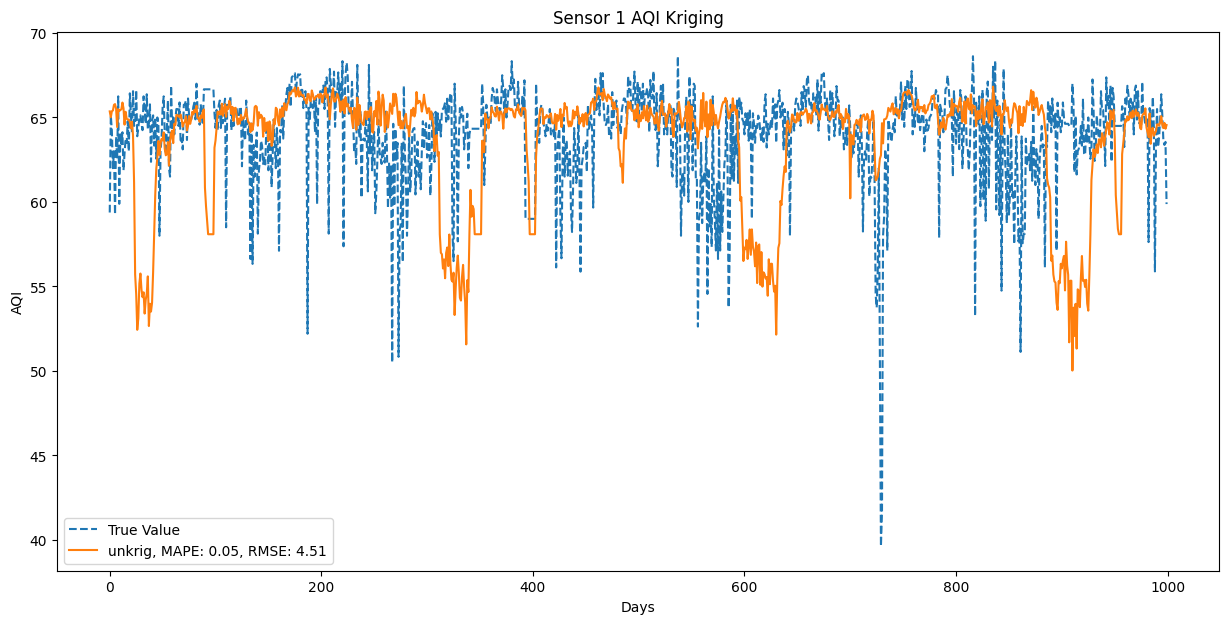

(6593, 24, 207, 1)


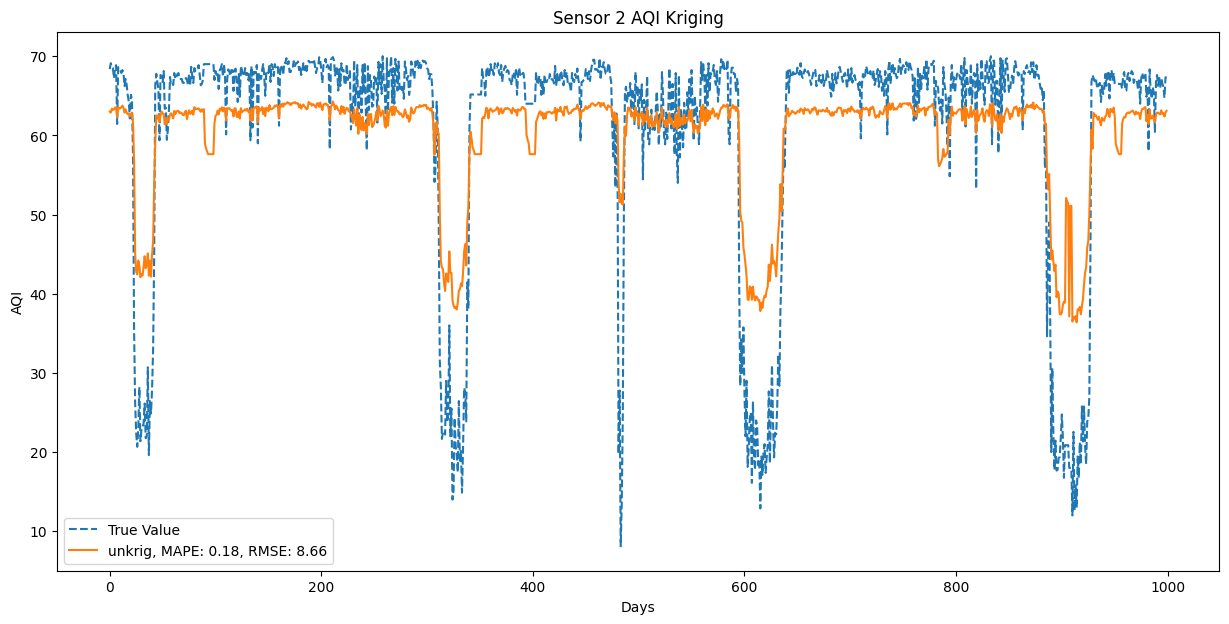

(6593, 24, 207, 1)


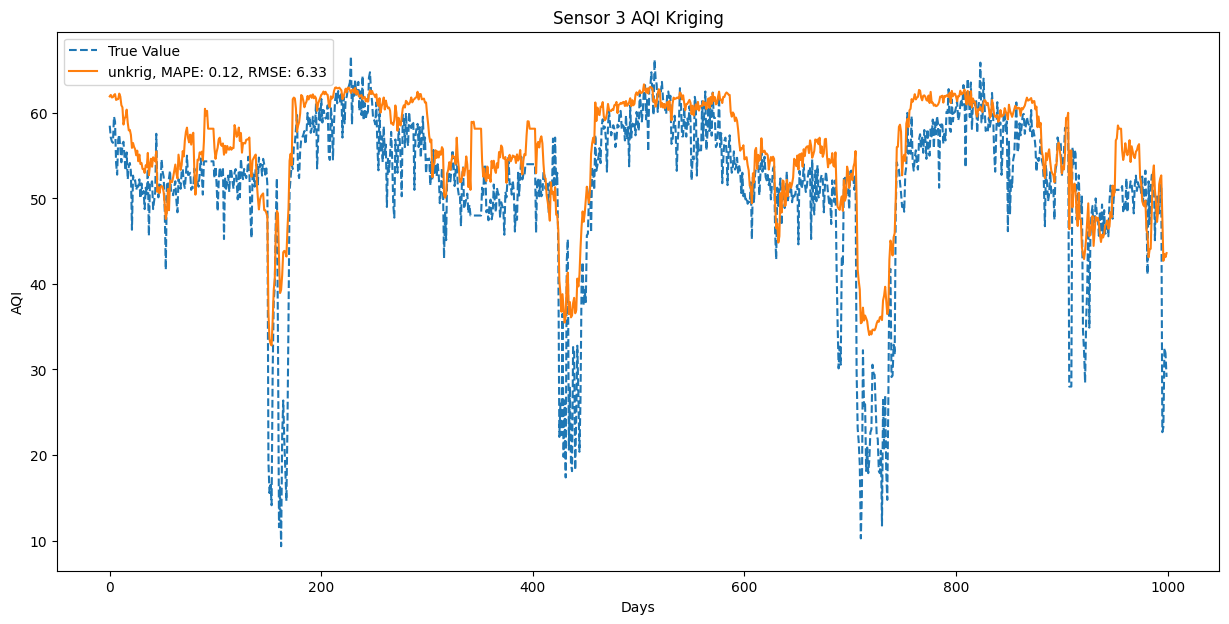

(6593, 24, 207, 1)


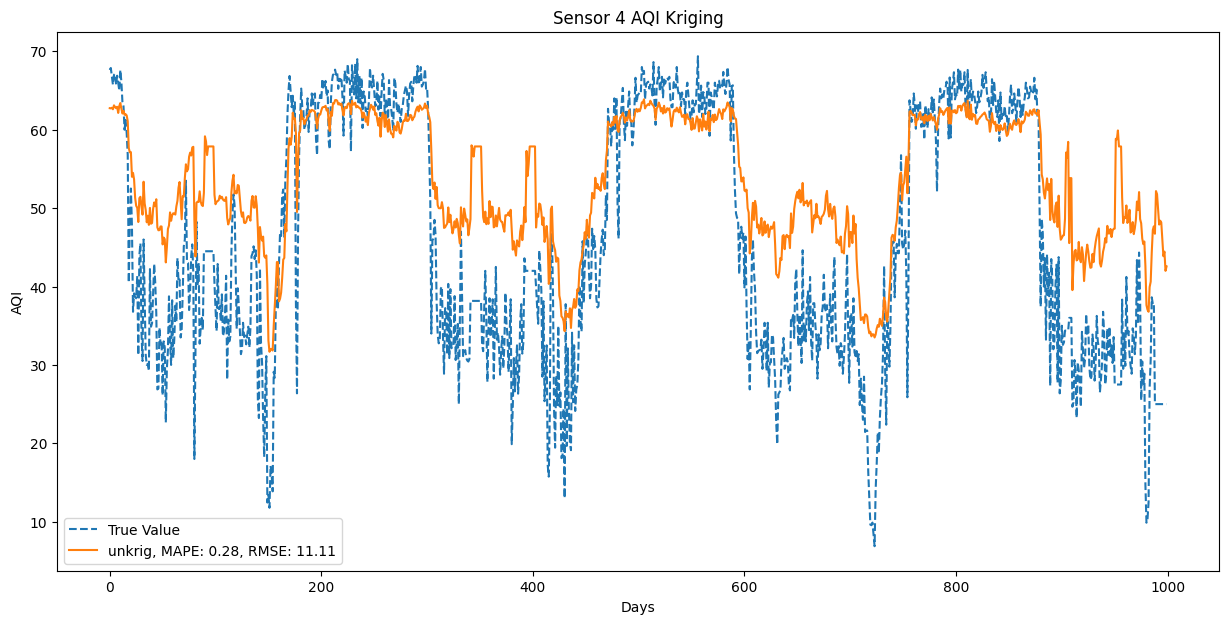

(6593, 24, 207, 1)


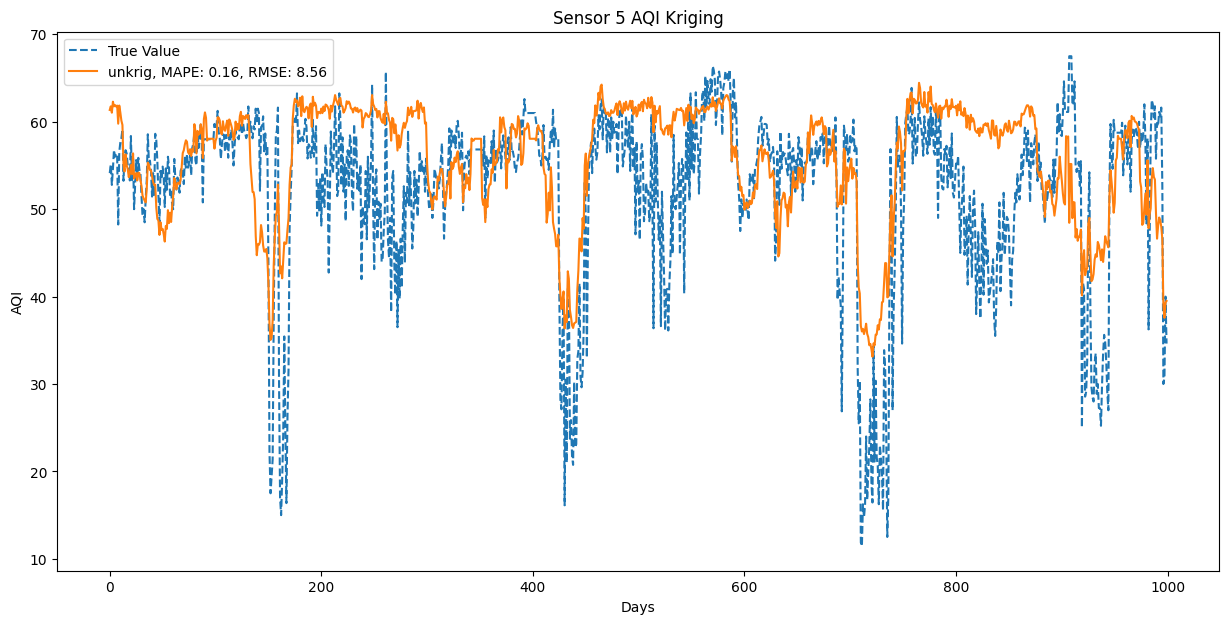

(6593, 24, 207, 1)


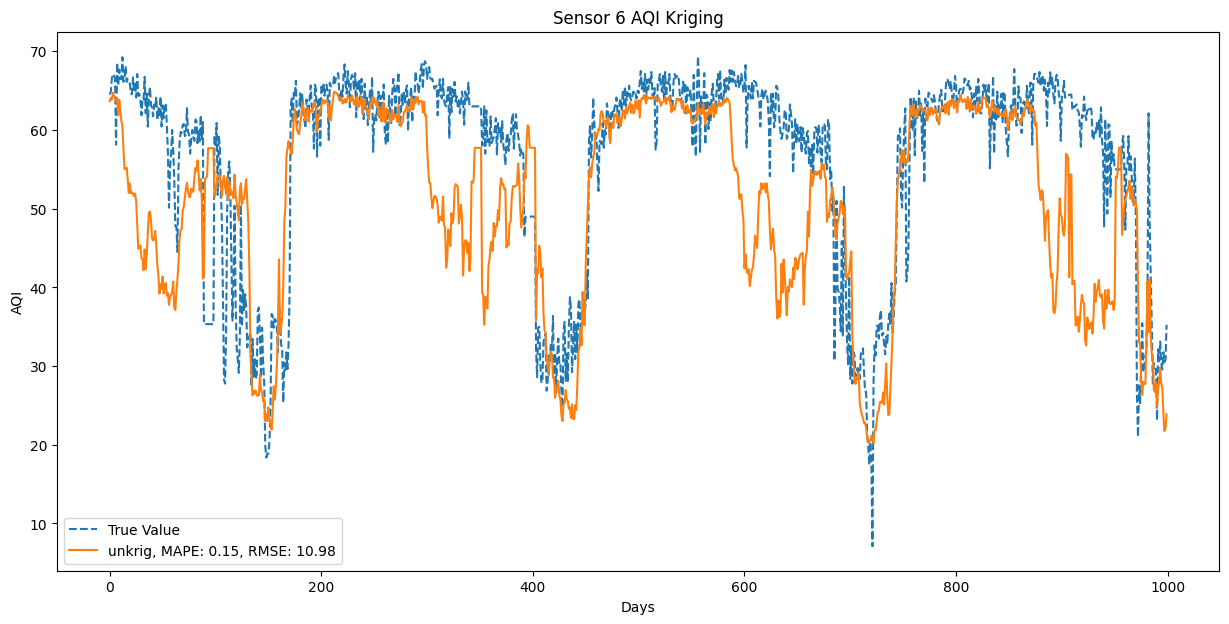

(6593, 24, 207, 1)


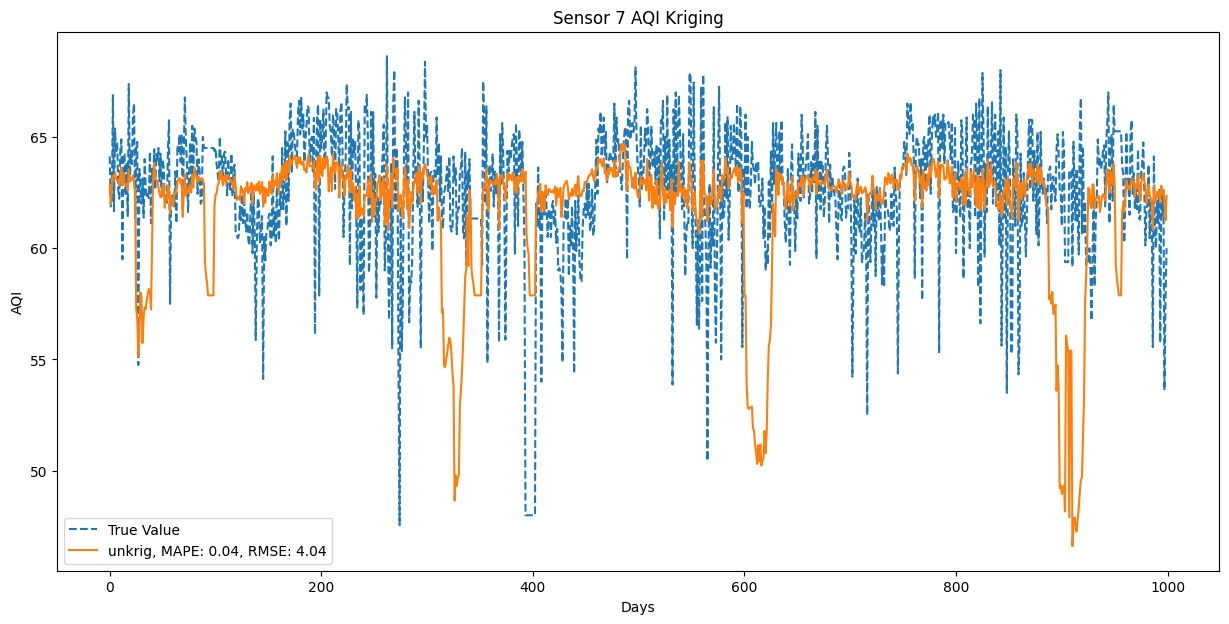

(6593, 24, 207, 1)


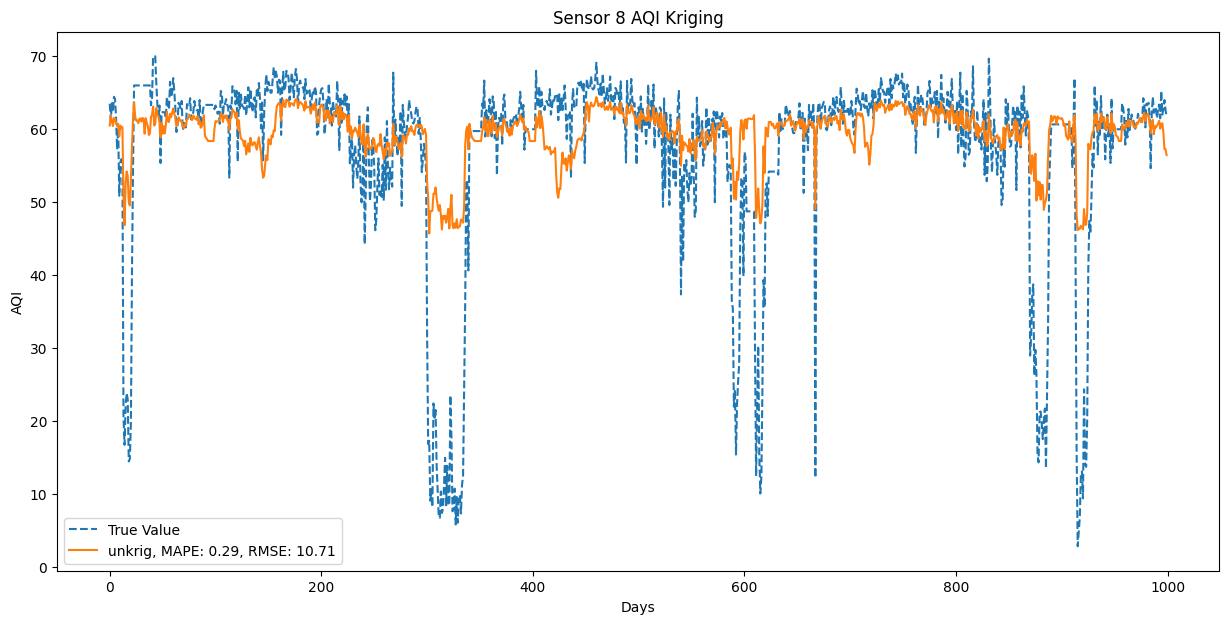

(6593, 24, 207, 1)


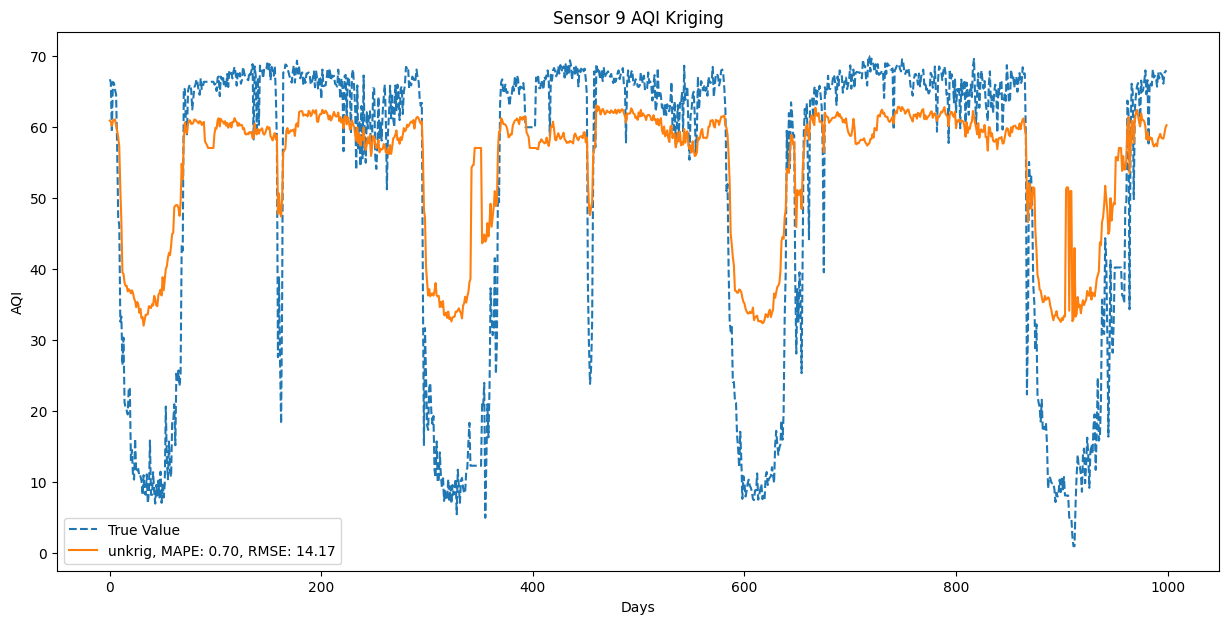

(6593, 24, 207, 1)


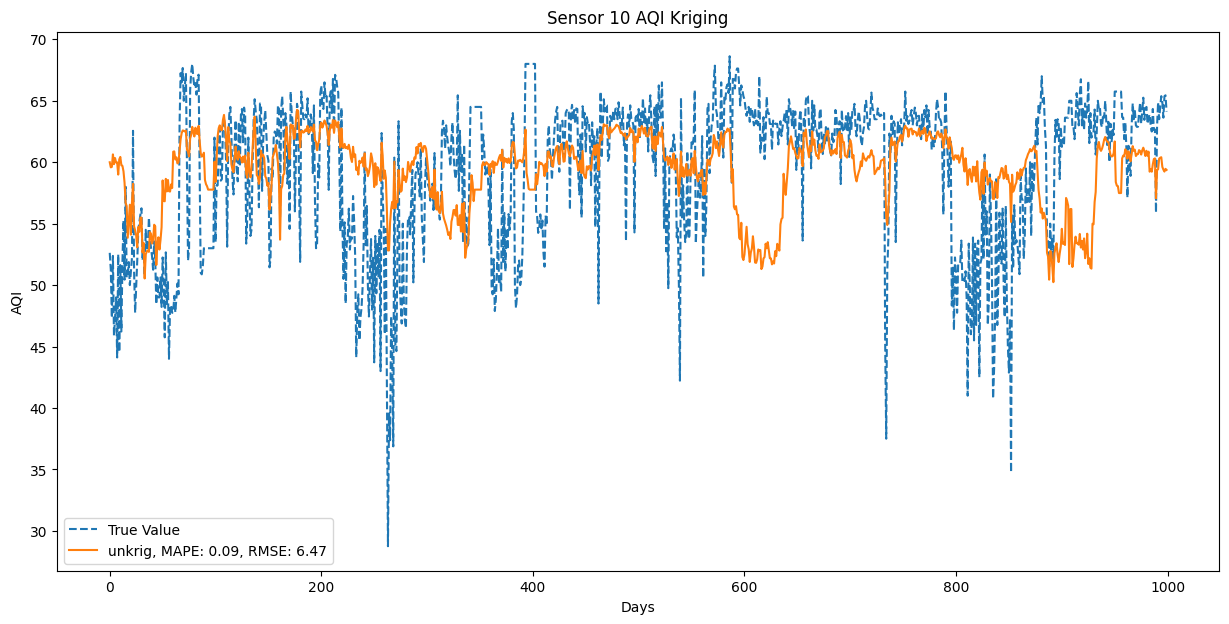

(6593, 24, 207, 1)


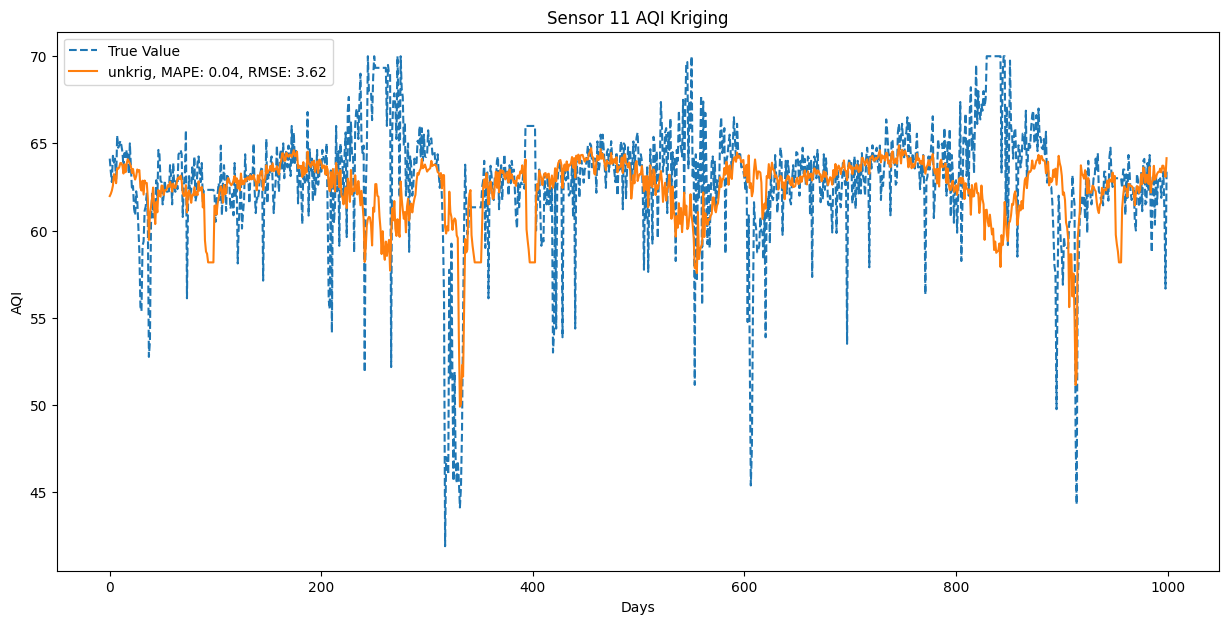

(6593, 24, 207, 1)


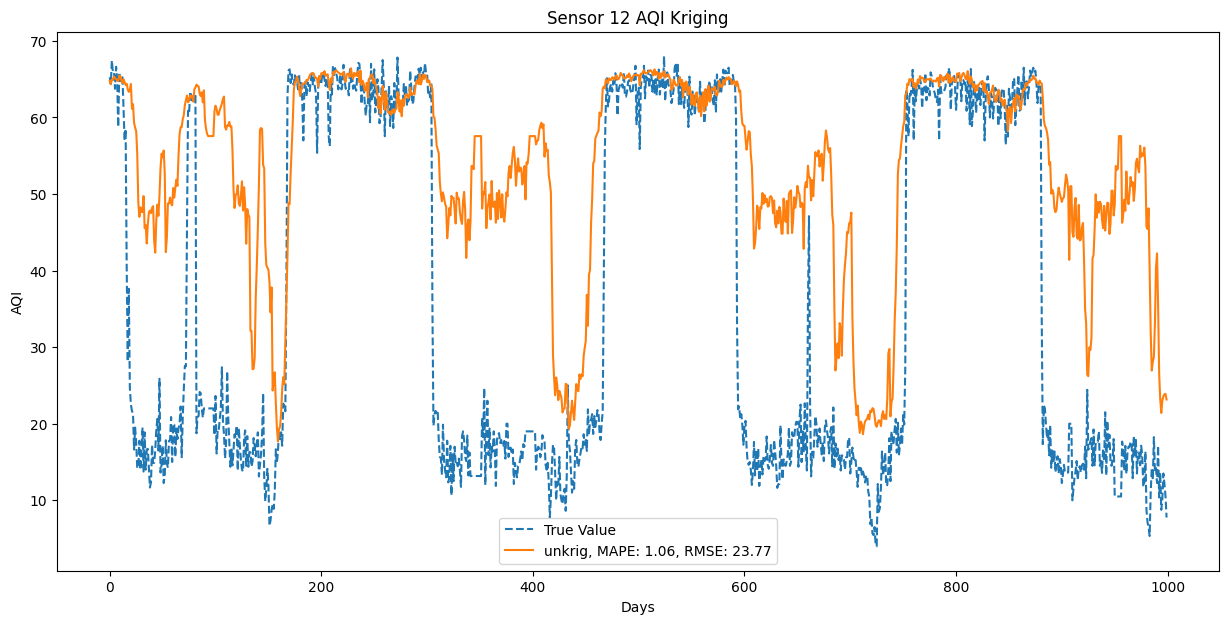

(6593, 24, 207, 1)


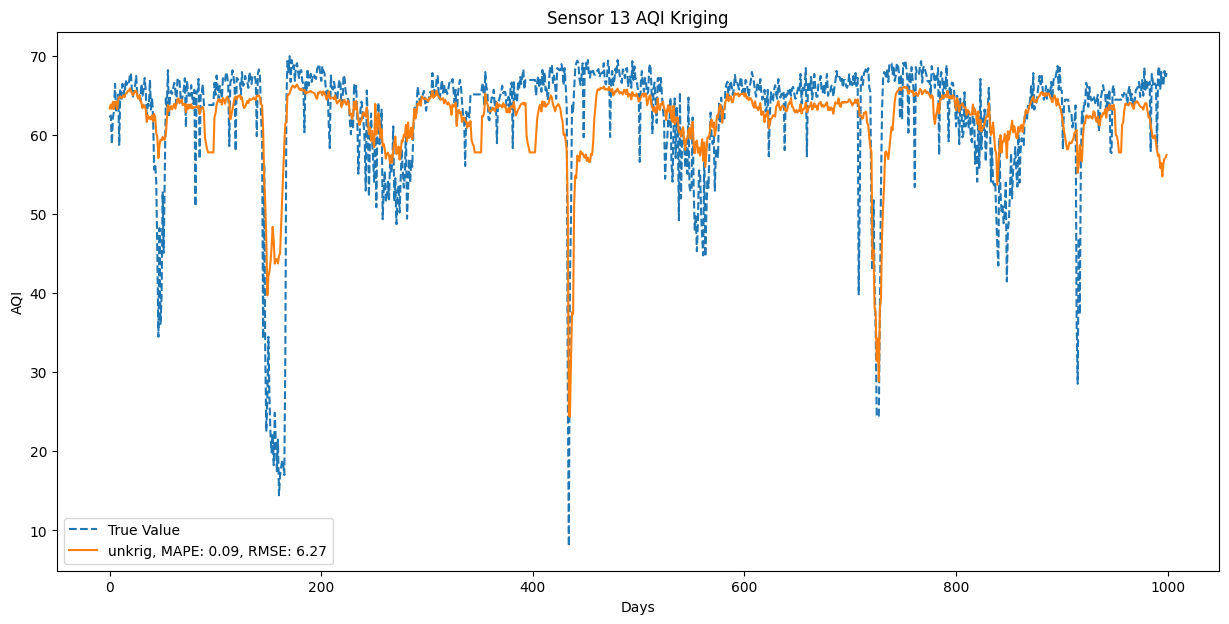

(6593, 24, 207, 1)


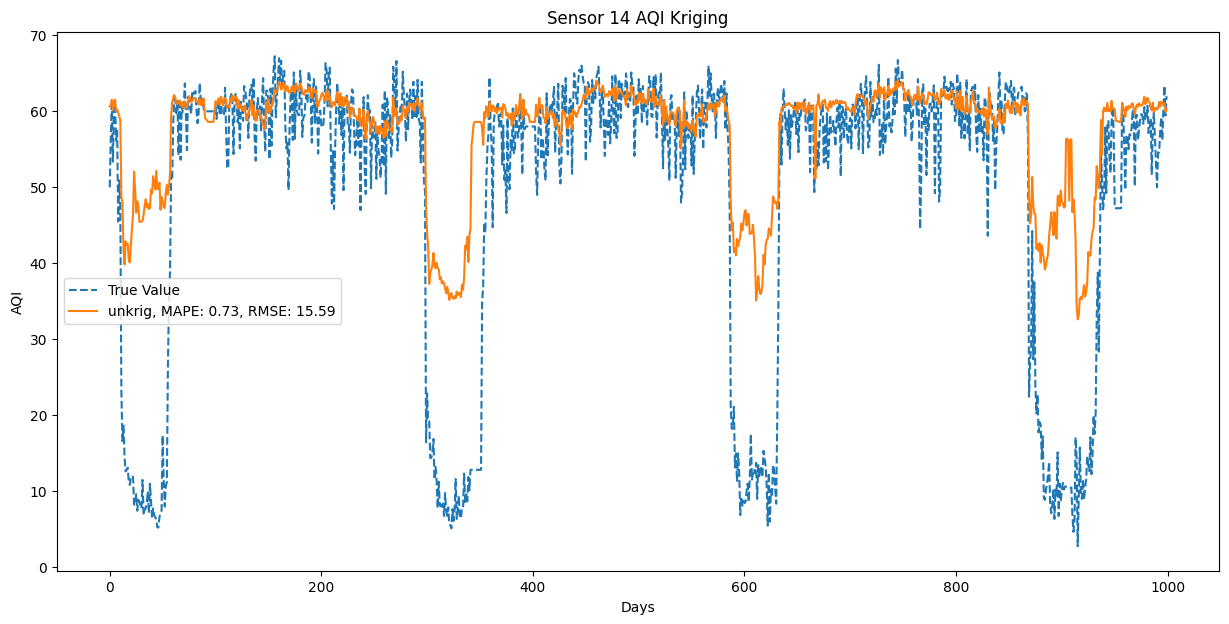

(6593, 24, 207, 1)


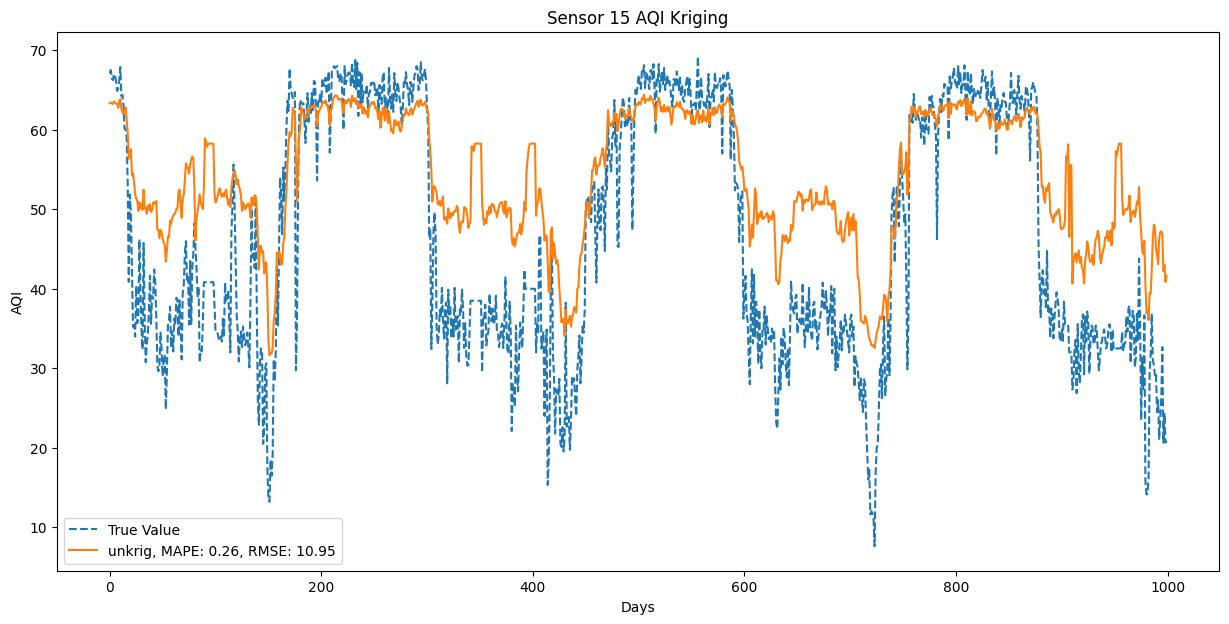

(6593, 24, 207, 1)


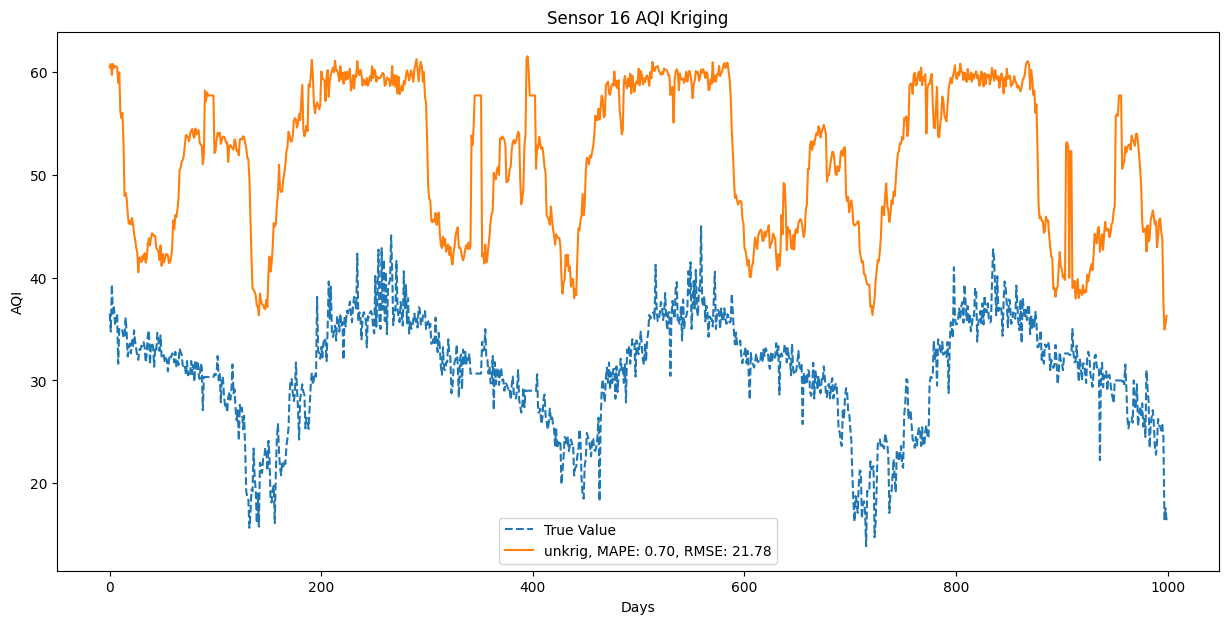

(6593, 24, 207, 1)


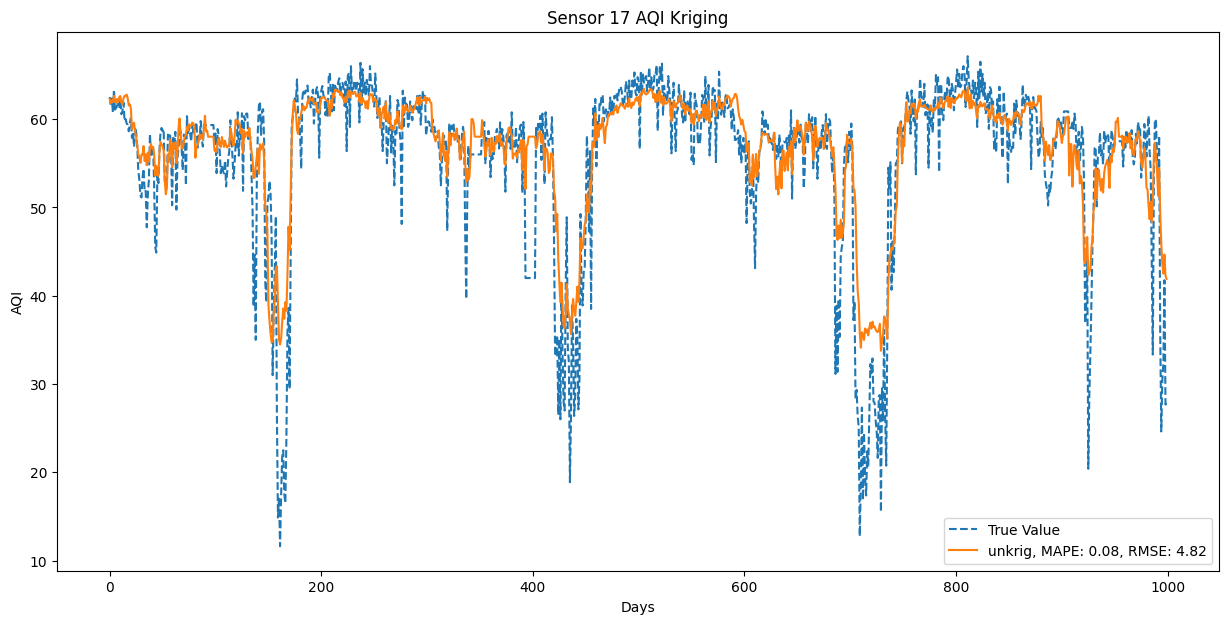

(6593, 24, 207, 1)


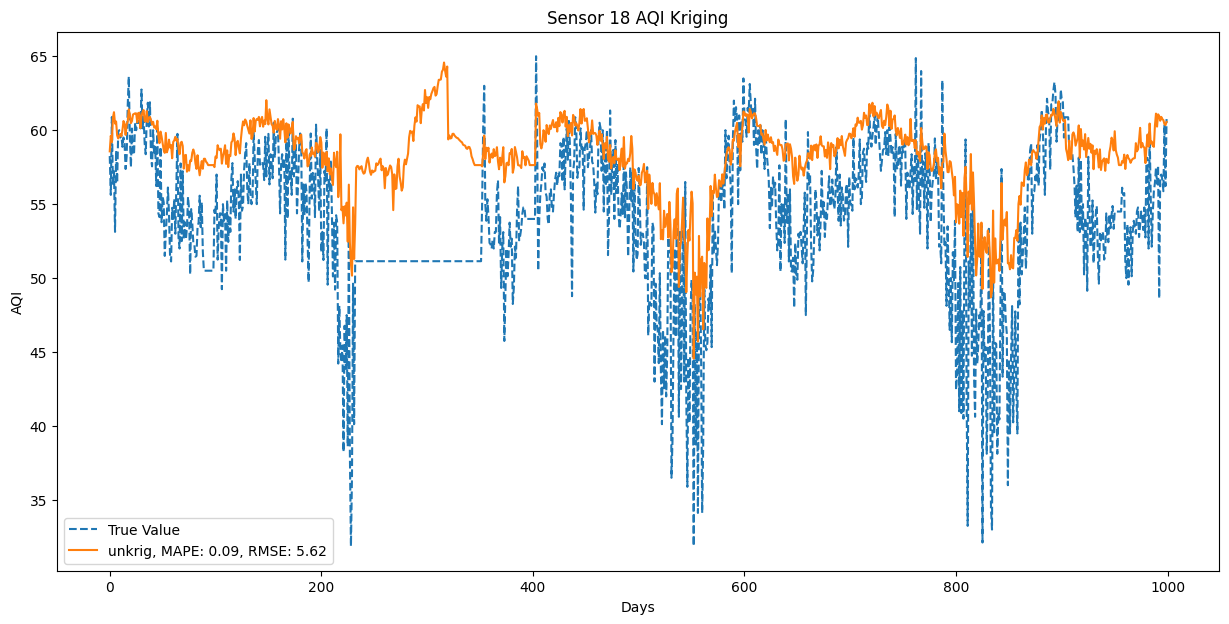

(6593, 24, 207, 1)


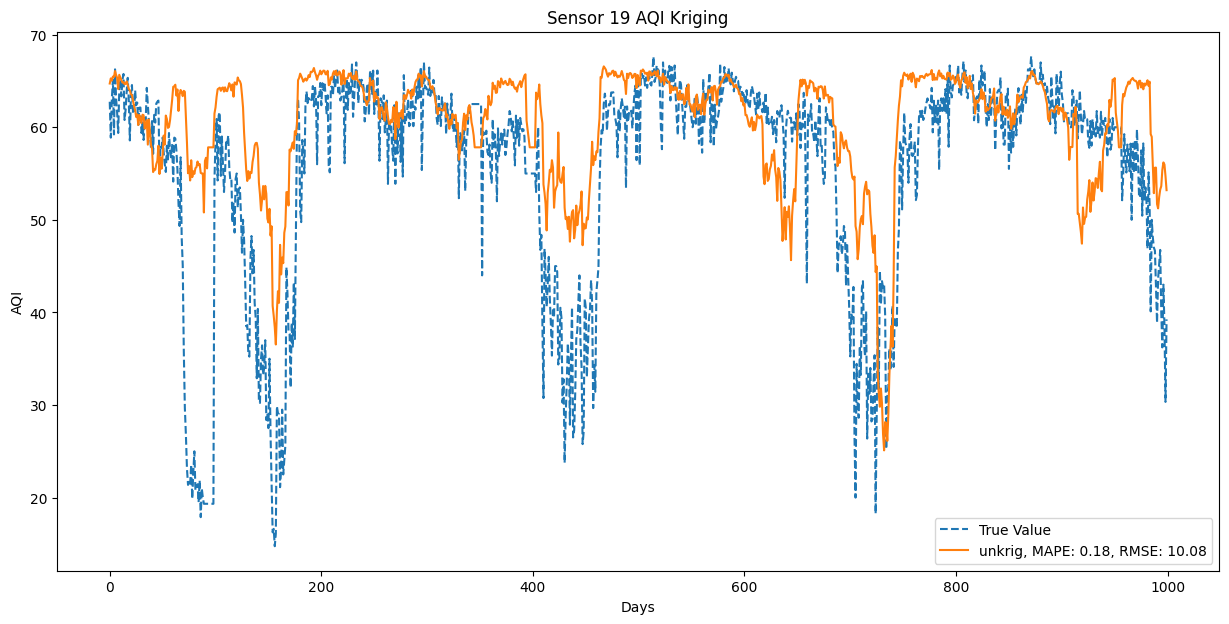

In [10]:
titles = ['unkrig']
styles = ['-']
ranges = [0, 1000]

sensors = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
sensors = [43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
# sensors = [5, 10, 31, 40, 71, 73, 83, 117, 122, 156, 164, 176]
sensors = [3, 7, 10, 11, 12, 13, 15, 21, 24, 26, 27, 37, 38, 44, 51] #, 56, 57, 59, 61, 62, 64, 65, 67, 72, 74, 81, 86, 87, 92, 95, 98, 99, 106, 108, 112, 113, 116, 118, 124, 126, 127, 129, 133, 138, 140, 142, 144, 145, 149, 155, 168, 179, 183, 184, 185, 188, 191, 192, 196, 206]
sensors = [ 21, 156, 121,  35,  50, 200,  10, 179, 126, 189,  90,  18, 203,
            107,  44,  92, 183, 202, 152, 171,  99, 118,  45,   8,  55,  65]
sensors = [194, 125]
sensors = [74, 80, 91, 93, 94, 96, 97, 98, 102, 103, 118, 119, 124, 127, 128, 136, 138, 144]
        # 3, 4, 5, 6, 12, 15, 16, 17, 19, 20, 22, 32, 33, 39, 57, 67, 68, 71, 72,
        # 74, 80, 91, 93, 94, 96, 97, 98, 102, 103, 118, 119, 124, 127, 128, 136, 138, 144
        # 154, 155, 157, 159, 160, 161, 162, 163, 166, 175, 187, 188, 190, 191, 192, 193, 195, 196, 198, 205, 206]
# sensors = range(1, 11)

sensors = [1, 6, 12, 13, 19, 21, 29, 36, 37, 39, 49, 52, 53, 54, 55, 56, 58, 59, 62, 72, 74]
        #    75, 77, 83, 84, 89, 95, 96, 100, 103, 105, 108, 109, 117, 119, 120, 122, 126, 133, 138, 139, 145, 149, 150, 153, 160, 161, 163, 165, 169, 170, 171, 196, 204, 206]

sensors = range(1, 20)
        #    72, 73, 74, 80, 81, 84, 86, 93, 97, 101, 104, 106, 114, 118, 122, 127, 135, 141, 142, 145, 150, 153, 157, 166, 167, 169, 175, 176, 178, 180, 181, 191, 193, 196, 200, 205, 206, 208, 215, 221, 223, 228, 229, 231, 233, 236, 240, 247, 250, 252, 256, 259, 260, 263, 265, 268, 273, 276, 277, 283, 285, 292, 297, 300, 302, 308, 309, 311, 318, 321, 322, 324, 328, 329, 332, 335, 338, 343, 350, 356, 358, 359, 360, 365, 370, 371, 373, 382, 385, 386, 388, 392, 395, 400, 401, 407, 409, 413, 417, 418, 419, 440, 442, 446, 448, 453, 458, 460, 463, 466, 472, 474, 475, 476, 477, 479, 486, 488, 489, 490, 493, 496, 498, 500, 502, 504, 507, 508, 509, 511, 513, 516, 521, 524, 525, 526, 527, 530, 533, 536, 537, 544, 547, 556, 557, 558, 562, 566, 567, 570, 574, 588, 594, 595, 599, 605, 609, 611, 612, 615, 618, 625, 628, 630, 636, 638, 639, 641, 671, 673, 678, 681, 685, 689, 695, 697, 704, 707, 710, 711, 718, 723, 729, 730, 733, 737, 741, 743, 747, 754, 755, 758, 763, 771, 774, 775, 776, 778, 786, 790, 793, 794, 811, 816, 817, 818, 821, 823, 831, 843, 846, 848, 850, 854, 855, 857, 859, 871, 873, 875]


# deets = [[y_hat, y_true, mask, res, dm, dataset]]
mape_deet = [0, 0]
rmse_deet = [0, 0]

for sensor in sensors:
    plt.figure(figsize=(15,7))
    y_true = deets[0][1]

    # y_true = np.where(deets[0][2] == 1, y_true, 400)

    plt.plot(y_true[ranges[0]:ranges[1], -1, sensor, :], '--', label='True Value')
    # plt.plot(deets[1][0][ranges[0]:ranges[1], 0, 33, :], '--', label='KITS')
    for ind, deet in enumerate(deets):
        # deet = deets[0]
        y_hat = deet[0]
        print(y_hat.shape)
        test_mape=numpy_metrics.mape(y_hat[ranges[0]:ranges[1], 0, sensor, :], 
                                    y_true[ranges[0]:ranges[1], 0, sensor, :])
        test_rmse=numpy_metrics.rmse(y_hat[ranges[0]:ranges[1], 0, sensor, :], 
                                    y_true[ranges[0]:ranges[1], 0, sensor, :])

    # if test_mre > 20:
        plt.plot(y_hat[ranges[0]:ranges[1], -1, sensor, :], label=f'{titles[ind]}, MAPE: {test_mape:.2f}, RMSE: {test_rmse:.2f}')
        mape_deet[ind] += test_mape
        rmse_deet[ind] += test_rmse
        # plt.plot(deet[1][ranges[0]:ranges[1], 0, 4, :], label=f'True Value')

    # plt.ylim((0, 100))
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.legend()
    plt.title(f'Sensor {sensor} AQI Kriging')
    plt.show()